In [1]:
import drjit as dr
import mitsuba as mi

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse, LOSS_FNS

mi.set_variant('cuda_ad_rgb')

In [2]:
integrator = {
    'type': 'direct_reparam',
}

In [3]:
from mitsuba.scalar_rgb import Transform4f as T

def reset_scene():
    return mi.load_dict({
    'type': 'scene',
    'integrator': integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': T.look_at(
                        origin=(0, 0, 2),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    ),
        'fov': 60,
        'film': {
            'type': 'hdrfilm',
            'width': 64,
            'height': 64,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    'wall': {
        'type': 'obj',
        'filename': '../scenes/meshes/rectangle.obj',
        'to_world': T.translate([0, 0, -2]).scale(2.0),
        'face_normals': True,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
        }
    },
    'bunny': {
        'type': 'ply',
        'filename': '../scenes/meshes/bunny.ply',
        'to_world': T.scale(6.5),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) },
        },
    },
    'light': {
        'type': 'obj',
        'filename': '../scenes/meshes/sphere.obj',
        'emitter': {
            'type': 'area',
            'radiance': {'type': 'rgb', 'value': [1e3, 1e3, 1e3]}
        },
        'to_world': T.translate([2.5, 2.5, 7.0]).scale(0.25)
    }
})

scene = reset_scene()

In [4]:
img_ref = mi.render(scene, seed=0, spp=1024)

mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [5]:
params = mi.traverse(scene)
initial_vertex_positions = dr.unravel(mi.Point3f, params['bunny.vertex_positions'])

In [6]:
def update_scene(params, trans_x, trans_y, angle):
    trafo = mi.Transform4f.translate([trans_x, trans_y, 0.0]).rotate([0, 1, 0], angle * 100.0)

    params['bunny.vertex_positions'] = dr.ravel(trafo @ initial_vertex_positions)
    params.update()

def apply_transformation(params, opt):
    opt['trans'] = dr.clamp(opt['trans'], -1.0, 1.0)
    opt['angle'] = dr.clamp(opt['angle'], -1.0, 1.0)
    return update_scene(params, opt['trans'].x, opt['trans'].y, opt['angle'])

In [7]:
from utils.global_opt import GlobalOptGrad, IterationStoppingCriteria, NotImprovingStoppingCriteria

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.de import DE

In [8]:
class BunnyGlobalOpt(GlobalOptGrad):
    def __init__(self):
        super().__init__(n_var=3, xl=-1.0, xu=1.0)

    def set_params_from_vector(self, params, vector):
        params[f'trans'] = mi.Point2f(vector[0], vector[1])
        params[f'angle'] = mi.Float(vector[2])

    def set_vector_from_params(self, params, vector):
        vector[0] = to_float(params[f'trans'].x)
        vector[1] = to_float(params[f'trans'].y)
        vector[2] = to_float(params[f'angle'])

    def apply_transformations(self, scene_params, params):
        apply_transformation(scene_params, params)

    def initialize_scene(self):
        scene = reset_scene()
        params = mi.traverse(scene)
        return scene, params

In [9]:
global_opt_bunnies = BunnyGlobalOpt()
loss_fn = lambda img: mse(img, img_ref)

In [10]:
res_ga, losses_ga = global_opt_bunnies.run(
    GA(pop_size=10, eliminate_duplicates=True),
    loss_fn,
    n_gen=10,
    grad_descent_stopping_criteria=IterationStoppingCriteria(max_iter=0),
    lr=0.025,
    spp=16,
    seed=0,
    verbose=True,
)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



[Gen. 10/10 Ind. 10/10	Best loss: 0.002794	Nb renderings: 199: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


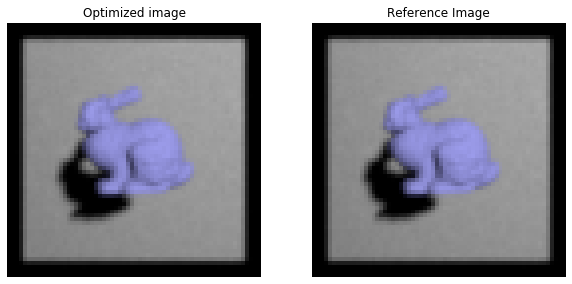

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(global_opt_bunnies.render_individual(res_ga.X, spp=1024))
axs[0].axis('off')
axs[0].set_title('Optimized image')

axs[1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1].axis('off')
axs[1].set_title('Reference Image');

In [17]:
res_ga, losses_ga = global_opt_bunnies.run(
    GA(pop_size=10, eliminate_duplicates=True),
    loss_fn,
    n_gen=3,
    grad_descent_stopping_criteria=IterationStoppingCriteria(max_iter=3),
    lr=0.025,
    spp=16,
    seed=0,
    verbose=True,
)

[Gen. 3/3 Ind. 10/10	Best loss: 0.006817	Nb renderings: 61: 100%|██████████| 3/3 [00:11<00:00,  3.78s/it]


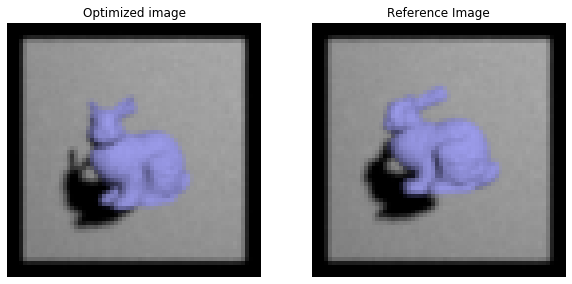

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(global_opt_bunnies.render_individual(res_ga.X, spp=1024))
axs[0].axis('off')
axs[0].set_title('Optimized image')

axs[1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1].axis('off')
axs[1].set_title('Reference Image');

In [15]:
res_ga, losses_ga = global_opt_bunnies.run(
    GA(pop_size=10, eliminate_duplicates=True),
    loss_fn,
    n_gen=5,
    grad_descent_stopping_criteria=NotImprovingStoppingCriteria(max_iter=5, eps=0.0),
    lr=0.025,
    spp=16,
    seed=0,
    verbose=True,
)

[Gen. 5/5 Ind. 10/10	Best loss: 0.002770	Nb renderings: 155: 100%|██████████| 5/5 [00:32<00:00,  6.46s/it]


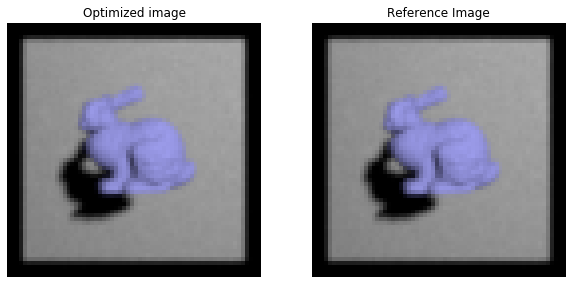

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(global_opt_bunnies.render_individual(res_ga.X, spp=1024))
axs[0].axis('off')
axs[0].set_title('Optimized image')

axs[1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1].axis('off')
axs[1].set_title('Reference Image');